In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

## Sentiment analysis setup

Let's first import all the necessary modules that our notebook will use as part of this project.

In [2]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
from keras.utils.vis_utils import plot_model
import numpy as np
import pandas as pd
import plotly.express as px
import plotly as pl
import datetime

#for confusion matrix
import seaborn
from sklearn.metrics import confusion_matrix


nltk.download('wordnet')
print('Done')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Done


In [3]:
train = pd.read_csv(r"D:\University\Semester 5\dwkm-assignment\tweet-sentiment-analysis\vaccination_all_tweets.csv")

Let's test whether it was loaded correctly by printing first 10 rows:

In [4]:
train.head(10)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


To make sure that the sentiment data is correct, let's check that it does not contain any other sentiment values than positive/negative/neutral:

In [5]:
train['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

Now let's take a look at the distribution of the dataset:

In [6]:
train.groupby('sentiment').nunique()

,textID,text,selected_text
sentiment,,,
negative,7781,7781,5861
neutral,11118,11117,11111
positive,8582,8582,5537


In [7]:
train = train[['selected_text','sentiment']]
train.head()

,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


Let's also ensure that there is no null value.

If there is, let's fill it.

In [8]:
if (train["selected_text"].isnull().sum() > 0):
    train["selected_text"].fillna("No content", inplace = True)

### The next steps about data cleaning will be:

* Remove URLs from the tweets
* Tokenize text
* Remove emails
* Remove new lines characters
* Remove distracting single quotes
* Remove all punctuation signs
* Lowercase all text
* Detokenize text
* Convert list of texts to Numpy array

In [9]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

temp = []
#Splitting pd.Series to list
data_to_list = train['selected_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['I`d have responded, if I were going',
 'Sooo SAD',
 'bullying me',
 'leave me alone',
 'Sons of ****,']

In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['have', 'responded', 'if', 'were', 'going'], ['sooo', 'sad'], ['bullying', 'me'], ['leave', 'me', 'alone'], ['sons', 'of'], ['some', 'shameless', 'plugging', 'for', 'the', 'best', 'rangers', 'forum', 'on', 'earth'], ['fun'], ['soooo', 'high'], ['both', 'of', 'you'], ['wow', 'just', 'became', 'cooler']]


## Detokenization, Stemming and Lemmatization

In [11]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)
    
data = []
for i in range(len(data_words)):
    
    #for j in range(len(data_words[i])):
        #stemming
        #data_words[i][j] = lancaster.stem(data_words[i][j])
        #lemmatization
        #data_words[i][j] = data_words[i][j].format(data_words[i][j],wordnet_lemmatizer.lemmatize(data_words[i][j]))
    
    data.append(detokenize(data_words[i]))
print(data[:10])

['have responded if were going', 'sooo sad', 'bullying me', 'leave me alone', 'sons of', 'some shameless plugging for the best rangers forum on earth', 'fun', 'soooo high', 'both of you', 'wow just became cooler']


In [12]:
data = np.array(data)

# Label encoding

As the dataset is categorical, we need to convert the sentiment labels from Neutral, Negative and Positive to a float type that our model can understand. To achieve this task, we'll implement the to_categorical method from Keras.

In [13]:
labels = np.array(train['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

# Data sequencing and splitting

We'll implement the Keras tokenizer as well as its pad_sequences method to transform our text data into 3D float data, otherwise our neural networks won't be able to be trained on it.

In [14]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...   68  146   41]
 [   0    0    0 ...    0  397   65]
 [   0    0    0 ...    0    0   11]
 ...
 [   0    0    0 ...  372   10    3]
 [   0    0    0 ...   24  542    4]
 [   0    0    0 ... 2424  199  657]]


In [15]:
print(labels)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [16]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

20610 6871 20610 6871


# Model building

## Model 1: SingleLSTM

In [17]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=1,validation_data=(X_test, y_test),callbacks=[checkpoint1])

645/645 [==============================] - 47s 69ms/step - loss: 0.9001 - accuracy: 0.5861 - val_loss: 0.6438 - val_accuracy: 0.7450

Epoch 00001: val_accuracy improved from -inf to 0.74502, saving model to best_model1.hdf5


## Model 2: Bidirectional LSTM

In [18]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
#model2 = keras.models.load_model('./best_model2.hdf5')
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=1,validation_data=(X_test, y_test),callbacks=[checkpoint2])

645/645 [==============================] - 63s 93ms/step - loss: 0.8774 - accuracy: 0.5977 - val_loss: 0.6717 - val_accuracy: 0.7041

Epoch 00001: val_accuracy improved from -inf to 0.70412, saving model to best_model2.hdf5


## Model 3: One-dimensional Convolutional Neural Network



In [19]:
from keras import regularizers
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model3.fit(X_train, y_train, epochs=1,validation_data=(X_test, y_test),callbacks=[checkpoint3])

645/645 [==============================] - 8s 12ms/step - loss: 1.2502 - acc: 0.5267 - val_loss: 0.9676 - val_acc: 0.5992


If you check the val_accuracy metric in the training logs you won't find better score than the one achieved by the BidRNN. Again, the previous model is not the best for this task becaue is majorly used for short translation tasks, but the good thing to notice is its speed to train.

Let's move on.

# Best model validation

Running the training has shown that Bidirectional RNN provides best accuracy.
Because of that, that's the network we're going to choose for our sentiment analysis.

In [20]:
#Let's load the best model obtained during training
best_model = keras.models.load_model("./best_model2.hdf5")

In [21]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

215/215 - 4s - loss: 0.6717 - accuracy: 0.7041
Model accuracy:  0.7041187882423401


In [22]:
predictions = best_model.predict(X_test)

## Confusion matrix

As accuracy is not a good metric to measure the quality of the model,
we are going to plot a confusion matrix:

<AxesSubplot:>

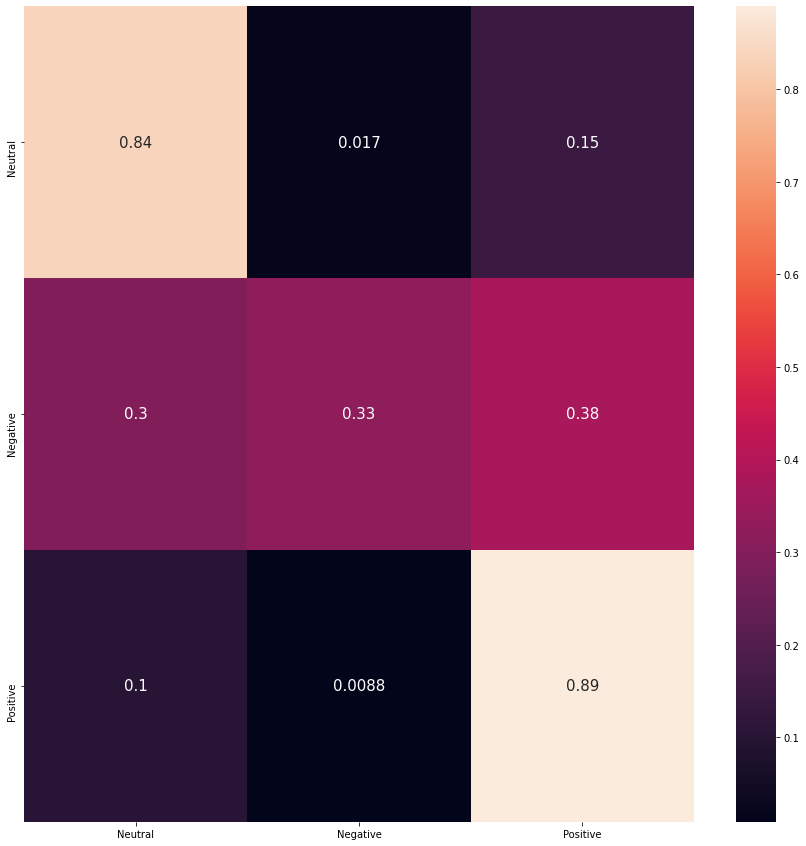

In [23]:
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
seaborn.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

Again, the model's score is very poor, but keep in mind it hasn't gone through hyperparameter tuning. Let's see how it perfoms on some sample texts:

In [24]:
sentiment = ['Neutral','Negative','Positive']

In [25]:
sequence = tokenizer.texts_to_sequences(['the trump administration failed to deliver on vaccine promises shocker covidiots coronavirus covidvaccine'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Neutral'

In [26]:
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Positive'

In [27]:
sequence = tokenizer.texts_to_sequences(['i hate youtube ads, they are annoying'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [28]:
sequence = tokenizer.texts_to_sequences(['i really loved how the technician helped me with the issue that i had'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Neutral'

Applying the model to COVID-19 Vaccination set

# COVID-19 Vaccination set




## Load set

In [29]:
covidtweets = pd.read_csv('../input/all-covid19-vaccines-tweets/vaccination_all_tweets.csv')
covidtweets.head(10)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False
5,1337852648389832708,Dee,"Birmingham, England","Gastroenterology trainee, Clinical Research Fe...",2020-01-26 21:43:12,105,108,106,False,2020-12-12 20:11:42,Does anyone have any useful advice/guidance fo...,NaN,Twitter for iPhone,0,0,False
6,1337851215875608579,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False
7,1337850832256176136,Dr.Krutika Kuppalli,NaN,"ID, Global Health, VHF, Pandemic Prep, Emergin...",2019-03-25 04:14:29,21924,593,7815,True,2020-12-12 20:04:29,There have not been many bright days in 2020 b...,"['BidenHarris', 'Election2020']",Twitter for iPhone,2,22,False
8,1337850023531347969,Erin Despas,NaN,Designing&selling on Teespring. Like 90s Disne...,2009-10-30 17:53:54,887,1515,9639,False,2020-12-12 20:01:16,Covid vaccine; You getting it?\n\n #CovidVacci...,"['CovidVaccine', 'covid19', 'PfizerBioNTech', ...",Twitter Web App,2,1,False
9,1337842295857623042,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafiansp...,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12 19:30:33,#CovidVaccine \n\nStates will start getting #C...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False


Let's examine the columns:

In [30]:
print(covidtweets['id'].nunique())
print(covidtweets['user_name'].nunique())
print(covidtweets['user_location'].nunique())
print(covidtweets['user_description'].nunique())
print(covidtweets['user_created'].nunique())
print(covidtweets['user_friends'].nunique())
print(covidtweets['user_favourites'].nunique())
print(covidtweets['user_verified'].nunique())
print(covidtweets['date'].nunique())
print(covidtweets['text'].nunique())
print(covidtweets['hashtags'].nunique())
print(covidtweets['source'].nunique())
print(covidtweets['retweets'].nunique())
print(covidtweets['favorites'].nunique())
print(covidtweets['is_retweet'].nunique())

46059
25553
9345
24494
25871
5199
16866
2
45622
46018
16835
171
239
503
1


Is there any null value?

In [31]:
covidtweets["text"].isnull().sum()

0

## Pre-processing

Just like with training set, we need to pre-process this set with the same rules:

In [32]:
temp = []
#Splitting pd.Series to list
data_to_list = covidtweets["text"].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech ',
 'While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort weve ev… ',
 '#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… ',
 'Facts are immutable, Senator, even when youre not ethically sturdy enough to acknowledge them. (1) You were born i… ',
 'Explain to me again why we need a vaccine #whereareallthesickpeople #PfizerBioNTech… ']

In [33]:
data_words = list(sent_to_words(temp))
print(data_words[:10])

[['same', 'folks', 'said', 'daikon', 'paste', 'could', 'treat', 'cytokine', 'storm', 'pfizerbiontech'], ['while', 'the', 'world', 'has', 'been', 'on', 'the', 'wrong', 'side', 'of', 'history', 'this', 'year', 'hopefully', 'the', 'biggest', 'vaccination', 'effort', 'weve', 'ev'], ['coronavirus', 'sputnikv', 'astrazeneca', 'pfizerbiontech', 'moderna', 'covid_', 'russian', 'vaccine', 'is', 'created', 'to', 'last', 'years'], ['facts', 'are', 'immutable', 'senator', 'even', 'when', 'youre', 'not', 'ethically', 'sturdy', 'enough', 'to', 'acknowledge', 'them', 'you', 'were', 'born'], ['explain', 'to', 'me', 'again', 'why', 'we', 'need', 'vaccine', 'pfizerbiontech'], ['does', 'anyone', 'have', 'any', 'useful', 'advice', 'guidance', 'for', 'whether', 'the', 'covid', 'vaccine', 'is', 'safe', 'whilst', 'breastfeeding'], ['it', 'is', 'bit', 'sad', 'to', 'claim', 'the', 'fame', 'for', 'success', 'of', 'vaccination', 'on', 'patriotic', 'competition', 'between', 'usa', 'canada', 'uk', 'and'], ['there'

In [34]:
data = []
for i in range(len(data_words)):
    
    #for j in range(len(data_words[i])):
        #stemming
        #data_words[i][j] = lancaster.stem(data_words[i][j])
        #lemmatization
        #data_words[i][j] = data_words[i][j].format(data_words[i][j],wordnet_lemmatizer.lemmatize(data_words[i][j]))
        
    data.append(detokenize(data_words[i]))
print(data[:5])

['same folks said daikon paste could treat cytokine storm pfizerbiontech', 'while the world has been on the wrong side of history this year hopefully the biggest vaccination effort weve ev', 'coronavirus sputnikv astrazeneca pfizerbiontech moderna covid_ russian vaccine is created to last years', 'facts are immutable senator even when youre not ethically sturdy enough to acknowledge them you were born', 'explain to me again why we need vaccine pfizerbiontech']


In [35]:
data = np.array(data)

Adding empty sentiment column:

In [36]:
covidtweets["sentiment"] = np.nan

## Applying model to COVID dataset

In [37]:
#covidtweets["sentiment"] = best_model.predict_classes(data)]
for i in range(len(temp)):
    sequence = tokenizer.texts_to_sequences([temp[i]])
    test = pad_sequences(sequence, maxlen=max_len)
    covidtweets["sentiment"][i] = sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]
    if (i % 461 == 0):
        percentage = i/len(temp) * 100
        formatted_percentage = "{:.0f}".format(percentage)
        print(formatted_percentage,"%")

0 %
1 %
2 %
3 %
4 %
5 %
6 %
7 %
8 %
9 %
10 %
11 %
12 %
13 %
14 %
15 %
16 %
17 %
18 %
19 %
20 %
21 %
22 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
30 %
31 %
32 %
33 %
34 %
35 %
36 %
37 %
38 %
39 %
40 %
41 %
42 %
43 %
44 %
45 %
46 %
47 %
48 %
49 %
50 %
51 %
52 %
53 %
54 %
55 %
56 %
57 %
58 %
59 %
60 %
61 %
62 %
63 %
64 %
65 %
66 %
67 %
68 %
69 %
70 %
71 %
72 %
73 %
74 %
75 %
76 %
77 %
78 %
79 %
80 %
81 %
82 %
83 %
84 %
85 %
86 %
87 %
88 %
89 %
90 %
91 %
92 %
93 %
94 %
95 %
96 %
97 %
98 %
99 %


Let's view first 10 results:

In [38]:
pd.set_option('display.max_colwidth', None)
covidtweets[["text", "sentiment"]].head(50)

,text,sentiment
0,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,Neutral
1,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",Neutral
2,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,Neutral
3,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",Neutral
4,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,Neutral
5,Does anyone have any useful advice/guidance for whether the COVID vaccine is safe whilst breastfeeding?… https://t.co/EifsyQoeKN,Neutral
6,"it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… https://t.co/IfMrAyGyTP",Neutral
7,There have not been many bright days in 2020 but here are some of the best \n1. #BidenHarris winning #Election2020… https://t.co/77u4f8XXfx,Neutral
8,Covid vaccine; You getting it?\n\n #CovidVaccine #covid19 #PfizerBioNTech #Moderna,Positive
9,"#CovidVaccine \n\nStates will start getting #COVID19Vaccine Monday, #US says \n#pakustv #NYC #Healthcare #GlobalGoals… https://t.co/MksOvBvs5w",Neutral


## Data analysis

First let's plot the distribution chart of different sentiments:

  sentiment  tweets
0  Negative     206
1   Neutral   38580
2  Positive    7273


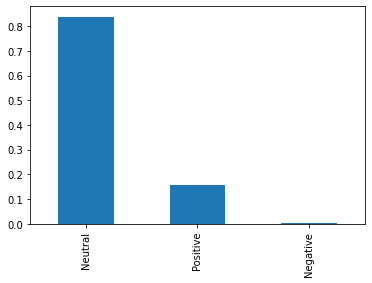

In [39]:
# Plot sentiment value counts
covidtweets['sentiment'].value_counts(normalize=True).plot.bar();

timeline = covidtweets.groupby(['sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()
print(timeline)
fig = px.bar(timeline,
            x='sentiment', y="tweets", color='sentiment', color_discrete_sequence=["#EF553B", "#636EFA", "#00CC96"]
        )
fig.show()

We neeed to exclude last day's data from the set as is it incomplete:

In [40]:
# Convert dates
covidtweets['date'] = pd.to_datetime(covidtweets['date'], errors='coerce').dt.date

# Get counts of number of tweets by sentiment for each date
timeline = covidtweets.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()

fig = px.line(timeline, x='date', y='tweets', color='sentiment', color_discrete_sequence=["#EF553B", "#636EFA", "#00CC96"], category_orders={'sentiment': ['neutral', 'negative', 'positive']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')
fig.show()

Z scores of negative sentiment for each vaccine:

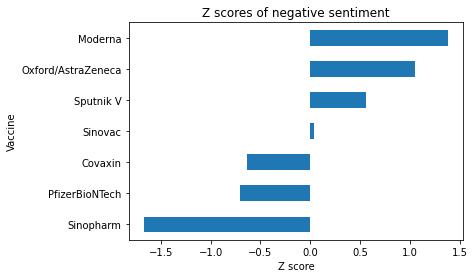

In [41]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik']

# Function to filter the data to a single vaccine and plot the timeline
# Note: a lot of the tweets seem to contain hashtags for multiple vaccines even though they are specifically referring to one vaccine - not very helpful!
def filtered_timeline(df, vax, title):
    df = df.dropna()
    title_str = 'Timeline showing sentiment of tweets about the '+title+' vaccine'
    df_filt = pd.DataFrame()
    for o in vax:
        df_filt = df_filt.append(df[df['text'].str.lower().str.contains(o)])
    other_vax = list(set(all_vax)-set(vax))
    for o in other_vax:
        df_filt = df_filt[~df_filt['text'].str.lower().str.contains(o)]
    df_filt = df_filt.drop_duplicates()
    timeline = df_filt.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index()
    fig = px.line(timeline, x='date', y='tweets', color='sentiment', category_orders={'sentiment': ['neutral', 'negative', 'positive']},title=title_str)
    fig.show()
    return df_filt

covaxin = filtered_timeline(covidtweets, ['covaxin'], title='Covaxin')
sinovac = filtered_timeline(covidtweets, ['sinovac'], title='Sinovac')
sinopharm = filtered_timeline(covidtweets, ['sinopharm'], title='Sinopharm')
moderna = filtered_timeline(covidtweets, ['moderna'], title='Moderna')
sputnikv = filtered_timeline(covidtweets, ['sputnik'], title='Sputnik V')
oxford = filtered_timeline(covidtweets, ['oxford', 'astrazeneca'], title='Oxford/AstraZeneca')
pfizer = filtered_timeline(covidtweets, ['pfizer', 'biontech'], title='Pfizer/BioNTech')

# Get z scores of sentiment for each vaccine
vax_names = {'Covaxin': covaxin, 'Sputnik V': sputnikv, 'Sinovac': sinovac, 'Sinopharm': sinopharm,
            'Moderna': moderna, 'Oxford/AstraZeneca': oxford, 'PfizerBioNTech': pfizer}
sentiment_zscores = pd.DataFrame()
for k, v in vax_names.items():
    senti = v['sentiment'].value_counts(normalize=True)
    senti['vaccine'] = k
    sentiment_zscores = sentiment_zscores.append(senti)
for col in ['Negative', 'Neutral', 'Positive']:
    sentiment_zscores[col+'_zscore'] = (sentiment_zscores[col] - sentiment_zscores[col].mean())/sentiment_zscores[col].std(ddof=0)
sentiment_zscores.set_index('vaccine', inplace=True)

# Plot the results
ax = sentiment_zscores.sort_values('Negative_zscore')['Negative_zscore'].plot.barh(title='Z scores of negative sentiment')
ax.set_ylabel('Vaccine')
ax.set_xlabel('Z score');

In [42]:
# Function to filter the data to a single date and print tweets from users with the most followers
def date_filter(df, date):
    return df[df['date'].astype(str)==date].sort_values('user_followers', ascending=False)[['date' ,'text']]

def date_printer(df, dates, num=10): 
    for date in dates:
        display(date_filter(df, date).head(num))

date_printer(moderna, ['2021-01-01', '2021-03-03'])

,date,text


,date,text
20114,2021-03-03,King Kullen has announced it received a limited supply of the first round of the #Moderna #COVID19 vaccines. \nhttps://t.co/UJWL4wgijZ
20183,2021-03-03,This is the definition of acute Stockholm Syndrome - he's been wildly ill after his experimental #Moderna mRNA gene… https://t.co/x1IAGkU5XA
20148,2021-03-03,"It's my second day after receiving my #Moderna #COVID19Vaccine too, and the incredible @GurdeepPandher captures the… https://t.co/Z6YHZv91Zh"
20202,2021-03-03,I'm happy to report that @JournalingIBD and myself received our 1st #Moderna vaccine on Monday and Tuesday this we… https://t.co/Ds5u68oTcn
20060,2021-03-03,#Moderna Suggests #Israel on its Radar for New #Vaccine Production Facility | United with Israel… https://t.co/hC9k6VfnA0
19234,2021-03-03,What a legend #Dolly #Moderna #COVID19 #vaccine @DollyParton https://t.co/wONZh9mF2q
19249,2021-03-03,I ❤ Dolly Parton.\nThanks for doing your civic and patriotic duty. #Moderna https://t.co/Gcsd3dP2yS
19292,2021-03-03,Dollllllyyy 😭😭😭\n#Moderna \n#COVID19Vaccine https://t.co/34dO14sGVT
19247,2021-03-03,"An example of how real artists should contribute in these difficult times.\n\nDolly made a big donation to #Moderna ,… https://t.co/aoIvjHudRQ"
20130,2021-03-03,"Got my first vaccination yesterday. My arm hurts a bit, but only when I use it. I'm also really drowsy. #Vaccine #Moderna"


In [43]:

covidtweets[covidtweets['text'].str.lower().str.contains("pfizer")].head(15)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,sentiment
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,['PfizerBioNTech'],Twitter for Android,0,0,False,Neutral
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0,False,Neutral
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternative news source from citizen journalists that haven't sold out. Real news & real views,2020-04-23 17:58:42,152,580,1473,False,2020-12-12,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,Neutral
8,1337850023531347969,Erin Despas,NaN,"Designing&selling on Teespring. Like 90s Disney tv movies, old school WWE. Dislikes Intolerance, hate, bigots and snakes https://t.co/fa5n4gEHgR",2009-10-30 17:53:54,887,1515,9639,False,2020-12-12,Covid vaccine; You getting it?\n\n #CovidVaccine #covid19 #PfizerBioNTech #Moderna,"['CovidVaccine', 'covid19', 'PfizerBioNTech', 'Moderna']",Twitter Web App,2,1,False,Positive
10,1337841934170255365,Tamer Yazar,Turkey-Israel,"Im Market Analyst, also Editor... working (freelance) for some companies that need analysis for their products in Int. Markets \n- Instagram : tamervisits -",2009-09-17 16:45:16,1302,78,339,False,2020-12-12,"while deaths are closing in on the 300,000 mark... millions of people wait #PfizerBioNTech #Vaccine !\n-\nThe first U… https://t.co/uQ3A2f7SVP","['PfizerBioNTech', 'Vaccine']",Twitter Web App,0,0,False,Neutral
11,1337840331522453507,VoiceM,NaN,campaigner & optimistic realist,2020-08-31 10:38:21,2,25,20,False,2020-12-12,@cnnbrk #COVID19 #CovidVaccine #vaccine #Corona #PfizerBioNTech #bbcnews #NYTimes #BBCNews Best wishes to the US… https://t.co/9xWmfU3LZj,"['COVID19', 'CovidVaccine', 'vaccine', 'Corona', 'PfizerBioNTech', 'bbcnews', 'NYTimes', 'BBCNews']",Twitter Web App,0,0,False,Positive
13,1337809196453081088,Dr.Krutika Kuppalli,NaN,"ID, Global Health, VHF, Pandemic Prep, Emerging Infections, & Health Policy MD| U.S. Congress COVID-19 expert witness x 2 | ELBI 2020 @JHSPH_CHS",2019-03-25 04:14:29,21924,593,7815,True,2020-12-12,For all the women and healthcare providers who have been asking about the safety of the #PfizerBioNTech… https://t.co/ow0Pglkwte,['PfizerBioNTech'],Twitter for iPhone,48,82,False,Neutral
16,1337789191598575616,STOPCOMMONPASS.ORG,Global,"'Trust' is not carte-blanche for erosion of our liberty, privacy, & the pursuit of global control.",2020-10-25 20:33:33,406,176,479,False,2020-12-12,UPDATED: #YellowFever &amp; #COVID19 #ImmunityPassports - Part Two\n\n#SARSCoV2 #PfizerBioNtech #Britain #December… https://t.co/qKT7Rst9aW,"['YellowFever', 'COVID19', 'ImmunityPassports', 'SARSCoV2', 'PfizerBioNtech', 'Britain', 'December']",Twitter Web App,2,2,False,Positive
17,1337783770070409218,ILKHA,Türkiye,Official Twitter account of Ilke News Agency /,2015-05-22 08:31:12,4056,6,3,True,2020-12-12,"Coronavirus: Iran reports 8,201 new cases, 221 deaths in the last 24 hours #Iran #coronavirus #PfizerBioNTech… https://t.co/mwDNAdmb7F","['Iran', 'coronavirus', 'PfizerBioNTech']",TweetDeck,3,5,False,Neutral
18,1337781178665816064,Braderz73🌹#GTTO 🇪🇺 🇬🇧,"Bristol, UK","One of those lefty types, I believe in a f

In [44]:
## Word clouds

In [45]:
!pip install wordninja pyspellchecker
from wordcloud import WordCloud, ImageColorGenerator
import wordninja
from spellchecker import SpellChecker
from collections import Counter
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))  
stop_words.add("amp")
import math
import random

     |████████████████████████████████| 541 kB 4.6 MB/s 
     |████████████████████████████████| 2.7 MB 42.2 MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541553 sha256=bf67034875089c6cce9428f2321909698ae144bafea2e422d750c3f011426f81
  Stored in directory: /root/.cache/pip/wheels/dd/3f/eb/a2692e3d2b9deb1487b09ba4967dd6920bd5032bfd9ff7acfc
Successfully built wordninja
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
# FUNCTIONS REQUIRED

def flatten_list(l):
    return [x for y in l for x in y]

def is_acceptable(word: str):
    return word not in stop_words and len(word) > 2

# Color coding our wordclouds 
def red_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(0, 100%, {random.randint(25, 75)}%)" 

def green_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl({random.randint(90, 150)}, 100%, 30%)" 

def yellow_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(42, 100%, {random.randint(25, 50)}%)" 

# Reusable function to generate word clouds 
def generate_word_clouds(neg_doc, neu_doc, pos_doc):
    # Display the generated image:
    fig, axes = plt.subplots(1,3, figsize=(20,10))
    
    wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neg_doc))
    axes[0].imshow(wordcloud_neg.recolor(color_func=red_color_func, random_state=3), interpolation='bilinear')
    axes[0].set_title("Negative Words")
    axes[0].axis("off")

    wordcloud_neu = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neu_doc))
    axes[1].imshow(wordcloud_neu.recolor(color_func=yellow_color_func, random_state=3), interpolation='bilinear')
    axes[1].set_title("Neutral Words")
    axes[1].axis("off")

    wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(pos_doc))
    axes[2].imshow(wordcloud_pos.recolor(color_func=green_color_func, random_state=3), interpolation='bilinear')
    axes[2].set_title("Positive Words")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show();

def get_top_percent_words(doc, percent):
    # Returns a list of "top-n" most frequent words in a list 
    top_n = int(percent * len(set(doc)))
    counter = Counter(doc).most_common(top_n)
    top_n_words = [x[0] for x in counter]
    
    return top_n_words
    
def clean_document(doc):
    spell = SpellChecker()
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatize words (needed for calculating frequencies correctly )
    doc = [lemmatizer.lemmatize(x) for x in doc]
    
    # Get the top 10% of all words. This may include "misspelled" words 
    top_n_words = get_top_percent_words(doc, 0.1)

    # Get a list of misspelled words 
    misspelled = spell.unknown(doc)
    
    # Accept the correctly spelled words and top_n words 
    clean_words = [x for x in doc if x not in misspelled or x in top_n_words]
    
    # Try to split the misspelled words to generate good words (ex. "lifeisstrange" -> ["life", "is", "strange"])
    words_to_split = [x for x in doc if x in misspelled and x not in top_n_words]
    split_words = flatten_list([wordninja.split(x) for x in words_to_split])
    
    # Some splits may be nonsensical, so reject them ("llouis" -> ['ll', 'ou', "is"])
    clean_words.extend(spell.known(split_words))
    
    return clean_words

def get_log_likelihood(doc1, doc2):    
    doc1_counts = Counter(doc1)
    doc1_freq = {
        x: doc1_counts[x]/len(doc1)
        for x in doc1_counts
    }
    
    doc2_counts = Counter(doc2)
    doc2_freq = {
        x: doc2_counts[x]/len(doc2)
        for x in doc2_counts
    }
    
    doc_ratios = {
        # 1 is added to prevent division by 0
        x: math.log((doc1_freq[x] +1 )/(doc2_freq[x]+1))
        for x in doc1_freq if x in doc2_freq
    }
    
    top_ratios = Counter(doc_ratios).most_common()
    top_percent = int(0.1 * len(top_ratios))
    return top_ratios[:top_percent]

# Function to generate a document based on likelihood values for words 
def get_scaled_list(log_list):
    counts = [int(x[1]*100000) for x in log_list]
    words = [x[0] for x in log_list]
    cloud = []
    for i, word in enumerate(words):
        cloud.extend([word]*counts[i])
    # Shuffle to make it more "real"
    random.shuffle(cloud)
    return cloud


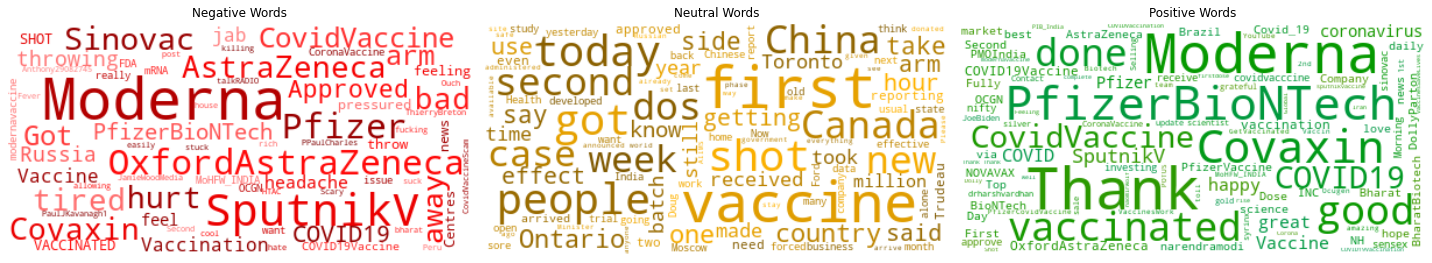

In [47]:
# Convert string to a list of words
covidtweets['words'] = covidtweets.text.apply(lambda x:re.findall(r'\w+', x ))

def get_smart_clouds(df):

    neg_doc = flatten_list(df[df['sentiment']=='Negative']['words'])
    neg_doc = [x for x in neg_doc if is_acceptable(x)]

    pos_doc = flatten_list(df[df['sentiment']=='Positive']['words'])
    pos_doc = [x for x in pos_doc if is_acceptable(x)]

    neu_doc = flatten_list(df[df['sentiment']=='Neutral']['words'])
    neu_doc = [x for x in neu_doc if is_acceptable(x)]

    # Clean all the documents
    neg_doc_clean = clean_document(neg_doc)
    neu_doc_clean = clean_document(neu_doc)
    pos_doc_clean = clean_document(pos_doc)

    # Combine classes B and C to compare against A (ex. "positive" vs "non-positive")
    top_neg_words = get_log_likelihood(neg_doc_clean, flatten_list([pos_doc_clean, neu_doc_clean]))
    top_neu_words = get_log_likelihood(neu_doc_clean, flatten_list([pos_doc_clean, neg_doc_clean]))
    top_pos_words = get_log_likelihood(pos_doc_clean, flatten_list([neu_doc_clean, neg_doc_clean]))

    # Generate syntetic a corpus using our loglikelihood values 
    neg_doc_final = get_scaled_list(top_neg_words)
    neu_doc_final = get_scaled_list(top_neu_words)
    pos_doc_final = get_scaled_list(top_pos_words)

    # Visualise our synthetic corpus
    generate_word_clouds(neg_doc_final, neu_doc_final, pos_doc_final)
    
get_smart_clouds(covidtweets)